In [1]:
### SE3nv for now, which do have pyrosetta
import os
import sys
import re
import random
import numpy as np
import pandas as pd
import glob
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
from shutil import copyfile
import tempfile
import shutil
from collections import defaultdict
#import xarray
import gzip
import time
import json
from Bio import SeqIO
import json
from sklearn import metrics


from sklearn.cluster import KMeans
import sklearn.metrics as sm
%matplotlib inline
pd.options.display.max_colwidth = 1000

sys.path.append('/home/lhtran/sc/')
from get_rmsds_functions import TMalign
from get_rmsds_functions import get_RMSD
import check_interactions_to_lig

from pyrosetta import *

from libSlurm import make_submit_file
from libSlurm import make_dist_plots
from libSlurm import sed_inplace
from libSlurm import grep
from libSlurm import get_flags
from libSlurm import plot_ROC
from libCommonJupyterFunc import get_total_scores
from check_interactions_to_lig import get_lig_num
from check_interactions_to_lig import get_hb2lig
from tqdm import tqdm

Matplotlib is building the font cache; this may take a moment.


In [2]:
home_dir = os.getcwd()

# home_dir = f'/home/lhtran/projects/small_binders/est_binder/'
# scratch_dir = f'/net/scratch/lhtran/est_binder/'
# os.chdir(home_dir)

In [3]:
def RMSD(V, W):
    """
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    Parameters
    ----------
    V : array
        (N,D) matrix, where N is points and D is dimension.
    W : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rmsd : float
        Root-mean-square deviation between the two vectors
    """
    diff = np.array(V) - np.array(W)
    N = len(V)
    return np.sqrt((diff * diff).sum() / N)

## MPNN + AF2

In [ ]:
## read pdb

In [5]:
test_pdb = f'{home_dir}/3nir.pdb'

In [16]:
### FTT test_pdb xyz coordinates
new_xyz = []
xyz = []
new_pdb = []
#simple_pdb = []
with open(test_pdb, 'r') as f:
    lines = f.readlines()
    for line in lines:
        atom_type = line[13:15].strip() #Ca/Cb/N/O/C
        if line.startswith('ATOM') and (atom_type == 'CA' or atom_type == 'CB' or atom_type =='N' or atom_type =='O' or atom_type=='C'):
            new_pdb.append(line)
            #xyz_true=(list(line[30:54].split(' ')))
            # xyz_np = []
            # for k in xyz_true:
            #     if k != '':
            #         xyz_np.append(float(k))
            # new_xyz.append(np.array(xyz_np))
            # xyz.append(np.fft.fftn(new_xyz))
            #print(atom_type)
            #print(xyz)
with open(f'{home_dir}/3nir_bb.pdb', 'w') as f:
    for line in new_pdb:
        f.write(line)

In [54]:
# FTT xyz coord of bb, noise, and inverse FTT
xyz_true = []
xyz_FTT = []
xyz_IFTT = []
with open(f'{home_dir}/3nir_bb.pdb', 'r') as f:
    lines = f.readlines()
    for line in lines:
        xyz_curr = []
        xyz = (list(line[30:54].split(' ')))
        for j in xyz:
            if j != '':
                xyz_curr.append(float(j))
        xyz_true.append(np.array(xyz_curr))

for i in xyz_true:
    xyz_ftt  = np.fft.fftn(i)
    xyz_FTT.append(xyz_ftt)
    xyz_IFTT.append(np.ndarray.round(np.real(np.fft.ifftn(xyz_ftt)), decimals=3))

In [73]:
with open(f'{home_dir}/3nir_bb.pdb', 'r') as f:
    lines = f.readlines()
    with open(f'{home_dir}/3nir_bb_FTT.pdb', 'w') as f2:
        for i,line in enumerate(lines):
            line = line[:30] + f"{(str(xyz_IFTT[i][0])):>8}" + line[38:]
            line = line[:38] + f"{(str(xyz_IFTT[i][1])):>8}" + line[46:]
            line = line[:46] + f"{(str(xyz_IFTT[i][2])):>8}" + line[54:]
            f2.write(line)
            #print(line[33:38], line[38:46], line[46:54])



In [10]:
xyz_plot = []
for tmp in xyz:
    xyz_plot.append(tmp[0])

In [15]:
len(xyz_plot)

305

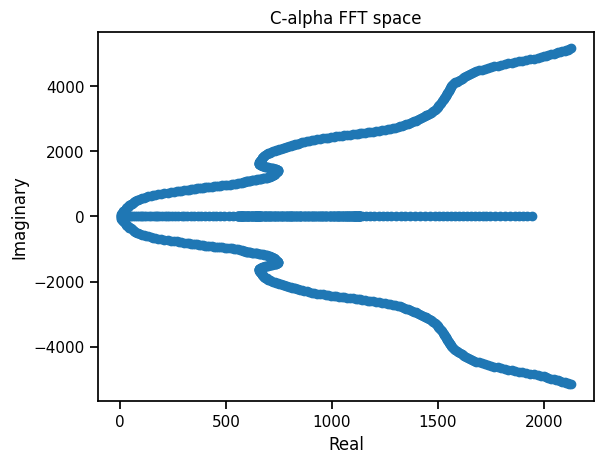

In [14]:
# Number of samplepoints
# N = 119
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
# #yf = scipy.fftpack.fft(y)
# yf = xyz_plot
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2][0]))
# ax.set(
#     xlim=(0, 100)
# )
# plt.show()
len(xyz_plot)
x_plot = [x.real for x in xyz_plot]
y_plot = [x.imag for x in xyz_plot]
plt.scatter(x_plot, y_plot)
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.title('C-alpha FFT space')
plt.show()

In [107]:
import get_pock_res_return as pockres

In [71]:
pdbs = [f'{home_dir}/3nir_bb.pdb', f'{home_dir}/3nir_bb_FTT.pdb']
cmds = []
for pdb in pdbs:

    pdb_name = pdb.split('/')[-1].split('.')[:-4]
    cmd = '/software/conda/envs/PPI_design/bin/python /home/lhtran/sc/mpnn_generic_tied_design2.py --design_these_chains A --keep_these_chains NA --tie_chainsa NA --tie_chainsb NA --tie_repeats 0 --fix_a NA'
    cmd += ' --fix_b NA --rmsd_cutoff 1.0 --max_designs_per_backbone 5 --num_seq_per_target 8 --sampling_temp " 0.2 0.3" --plddt_cutoff 0.9 --ptm_cutoff 0.65 --pdb_path '
    cmd += pdb
    cmd += f' --out_name resampling --suffix _pbias --pdb_out_dir /home/lhtran/class/cheme_577/mpnn_af2/pdbs'
    cmd += '\n'
    cmds.append(cmd)
    # with open(f'{home_dir}/mpnn_af2/{pdb}/array_task_mpnn_af2', 'w') as fp:
    #     for j in cmds:
    #         fp.write(j)

In [72]:
cmds[0],cmds[1]

('/software/conda/envs/PPI_design/bin/python /home/lhtran/sc/mpnn_generic_tied_design2.py --design_these_chains A --keep_these_chains NA --tie_chainsa NA --tie_chainsb NA --tie_repeats 0 --fix_a NA --fix_b NA --max_designs_per_backbone 5 --num_seq_per_target 8 --sampling_temp " 0.2 0.3" --plddt_cutoff 0.9 --ptm_cutoff 0.65 --pdb_path /mnt/home/lhtran/class/cheme_577/3nir_bb.pdb --out_name resampling --suffix _pbias --pdb_out_dir /home/lhtran/class/cheme_577/mpnn_af2/pdbs\n',
 '/software/conda/envs/PPI_design/bin/python /home/lhtran/sc/mpnn_generic_tied_design2.py --design_these_chains A --keep_these_chains NA --tie_chainsa NA --tie_chainsb NA --tie_repeats 0 --fix_a NA --fix_b NA --max_designs_per_backbone 5 --num_seq_per_target 8 --sampling_temp " 0.2 0.3" --plddt_cutoff 0.9 --ptm_cutoff 0.65 --pdb_path /mnt/home/lhtran/class/cheme_577/3nir_bb_FTT.pdb --out_name resampling --suffix _pbias --pdb_out_dir /home/lhtran/class/cheme_577/mpnn_af2/pdbs\n')

## SuperFold/ESMFold

In [7]:
## prep pdb input from ligMPNN_FR
ligmpnn_fr_scores = pd.read_csv(f'{home_dir}/ligmpnn_fr_scores_all.csv')
len(ligmpnn_fr_scores)/20 #1494